# 2D ERT modeling and inversion (Complex)
### This one tries to copy the deposit shape and simulate the geothermal plume as a diffusing fluid

There are also some changes to optimize the geometry and the inversion

In [253]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

## Geometry definition

In [254]:
world = mt.createWorld(start=(-100, -40), end=(100, 0))

### Define geology below the deposit

Fault and inyection point definition

In [255]:
iPos = (-49,-15) #Inyection Point
iPos2 = (50, -15) #Inyection Point 2
fault = mt.createPolygon([(-100, -40), (-100, -3), (-52, -5), iPos, (-40, -40)], isClosed= True)

Define Floresta and Cretacic

In [256]:
layer = mt.createPolygon([iPos, iPos2, (100, -8)], 
                         addNodes=100, interpolate='spline', isClosed=False)

Define Geometry

(<Axes: >, None)

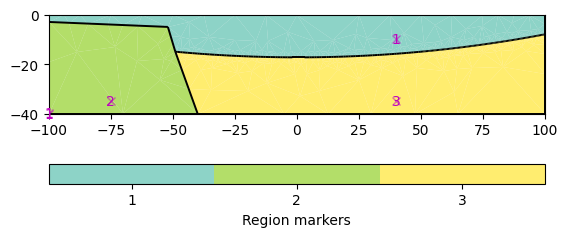

In [257]:
world += layer
world += fault

world.addRegionMarker((40, -10), marker=1)
world.addRegionMarker((-75, -35), marker=2)
world.addRegionMarker((40, -35), marker=3)

pg.show(world)

## Synthetic data generation
Create a Schlumberger ('slm') measuring scheme with 96 electrodes along a 700m line (-350 to 350)


(<Axes: >, None)

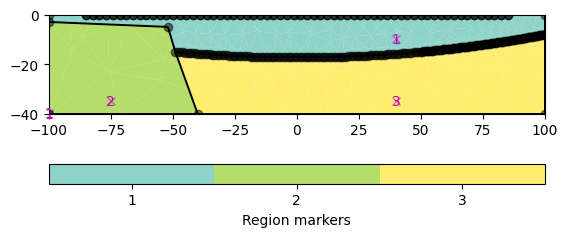

In [258]:
# Sensors should no be on the corner so we put them a little inside
scheme = ert.createData(elecs=np.linspace(start=-85, stop=85, num=64),
                           schemeName='gr')

# we need local refinement at the electrodes to achieve sufficient accuracy
for p in scheme.sensors():
    world.createNode(p)
    world.createNode(p - [0, 0.1])

pg.show(world, showNodes=True)

**IMPORTANT:** Mesh needs to be created after adding electrodes to world geometry

In [259]:
mesh = mt.createMesh(world, quality=33, area=100)

We need larger boundary to avoid numerical issues.
Note: appendTriangleBoundary is just an easier approach, but we can get better results if we create the boundary manually on geometry level.

Add rho values to our mesh

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f9d623aa830>)

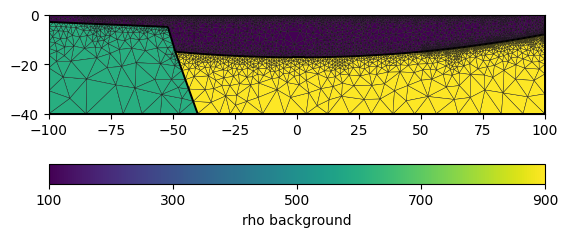

In [260]:
rhoMin = 1
rhoMax = 100
rho0 = pg.solver.cellValues(mesh, {1: 100,
                                   2: 600,
                                   3: 900,}
                                   )

pg.show(mesh, rho0, label='rho background', showMesh=True)

Simulate the ert with our forward mesh

ModellingBase::setMesh() copying new mesh ... Found datafile: 64 electrodes
Found: 64 free-electrodes
rMin = 1.34921, rMax = 340
NGauLeg + NGauLag for inverse Fouriertransformation: 14 + 4
Found non-Neumann domain
0.0637465 s
FOP updating mesh dependencies ... 6.6e-06 s
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.030000267608912237 : 0.03000486367695074
Calculating response for model: min = 100 max = 900
Allocating memory for primary potential...... 0.0038792

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 1.0349s
Response: min = 101.08 max = 331.823 mean = 145.83
Reciprocity rms(modelReciprocity) 2.57451%, max: 25.4987%


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f9d68d1ffa0>)

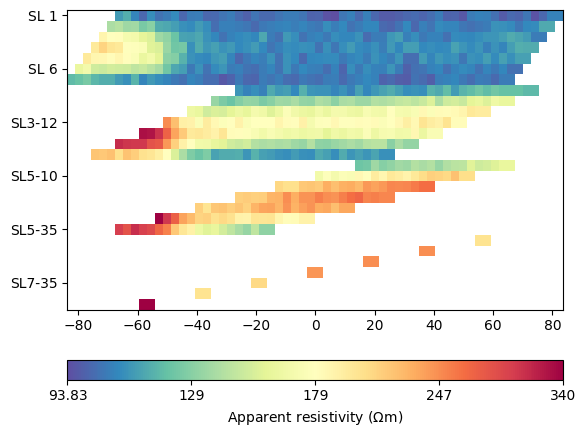

In [261]:
data = ert.simulate(mesh, scheme=scheme, res=rho0, 
                    noiseLevel=3, noiseAbs=1e-6, seed=1337)

pg.show(data)

### Define diffusive fluid

The flow can be either anisotropic or isotropic

Mesh:  Mesh: Nodes: 4846 Cells: 8928 Boundaries: 13773
Assembling time:  0.0524062
Solving time:  0.269845699


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f9d5d7f15d0>)

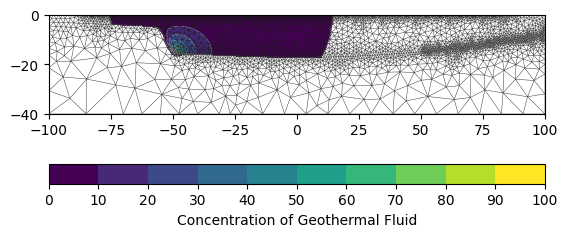

In [262]:
#Anisotropic flow
# diff = pg.solver.cellValues(mesh, {'3,2,4': pg.solver.createAnisotropyMatrix(0.1, 0.1, 0.0), 1: pg.solver.createAnisotropyMatrix(1, 100, 20.0*np.pi/180)}) 

#Isotropic and homogeneous flow
diff = pg.solver.cellValues(mesh, {4: 1e-2, 3: 1e-2, 2: 1e-2, 1: 100}) 

iPosID = mesh.findNearestNode(iPos)
iPosID2 = mesh.findNearestNode(iPos2)

# stationary solution 
Conc = pg.solver.solve(mesh, a=diff,
                    bc={'Dirichlet': {'-1': 0.0}, 'Neumann': {'-2': -1},
                        'Node':[[iPosID, 100]]}, verbose=True)

pg.show(mesh, Conc, label='Concentration of Geothermal Fluid', showMesh=True, 
        cMin=0, cMax=100, nCols=10, nLevs=11, linewidths=0.5)

### Simulate resistivity of the diffusive fluid according to the concentration

In [263]:
Conc = pg.interpolate(mesh, Conc, mesh.cellCenters())
Conc[Conc < 0] = 0

# add anomal resistivity as linear function from rhoMin to rhoMax depending on concentration
rho = 1/(1/np.array(rho0) + 1/(rhoMin)*(Conc/100))

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f9d69cc8fd0>)

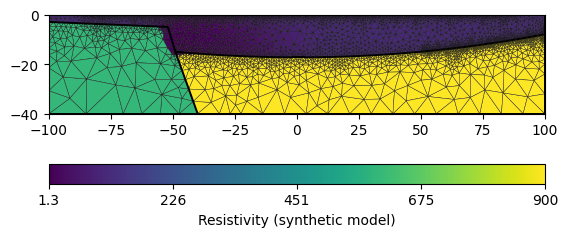

In [264]:
pg.show(mesh, rho, label='Resistivity (synthetic model)', showMesh=True,)

In [265]:
data = ert.simulate(mesh, scheme=scheme, res=rho, noiseLevel=3,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

07/04/24 - 17:03:35 - pyGIMLi - INFO - 0.8401095772636039 3265.061248264994
07/04/24 - 17:03:35 - pyGIMLi - INFO - Simulated data Data: Sensors: 64 data: 784, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
07/04/24 - 17:03:35 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
07/04/24 - 17:03:35 - pyGIMLi - INFO - Simulated rhoa (min/max) 4.95139152953164 343.58434834199977
07/04/24 - 17:03:35 - pyGIMLi - INFO - Selected data noise %(min/max) 3.000027245818524 3.008969378396405


ModellingBase::setMesh() copying new mesh ... relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.030000272458185238 : 0.03008969378396405
Found datafile: 64 electrodes
Found: 64 free-electrodes
rMin = 1.34921, rMax = 340
NGauLeg + NGauLag for inverse Fouriertransformation: 14 + 4
Found non-Neumann domain
0.0523651 s
FOP updating mesh dependencies ... 3.3e-06 s
Calculating response for model: min = 1.29668 max = 900
Allocating memory for primary potential...... 0.0018745

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.973855s
Response: min = 13.817 max = 322.817 mean = 103.311
Reciprocity rms(modelReciprocity) 205.177%, max: 4268.4%


Filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



07/04/24 - 17:03:35 - pyGIMLi - INFO - Filtered rhoa (min/max) 4.95139152953164 343.58434834199977


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f9d683d5330>)

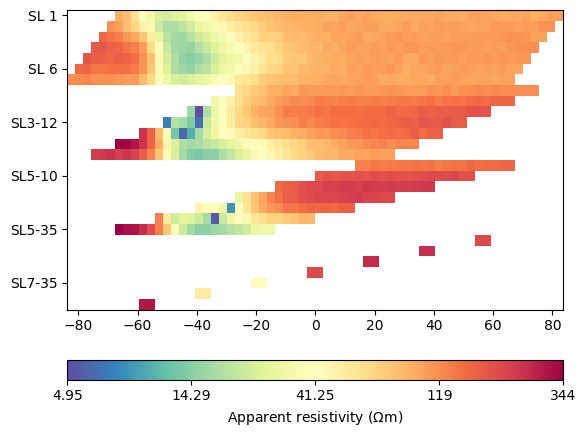

In [266]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('Forward_mod.dat')

# You can take a look at the data
ert.show(data)

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [267]:
mgr = ert.ERTManager('Forward_mod.dat')

Run the inversion with the preset data. 
Since I set noise level to 3%, chi^2 target should be close to 0.9 or sighly above, also the regularization parameter should be in the range of 10 to 50 (I chose 30).



In [268]:
inv = mgr.invert(secNodes=1, paraMaxCellSize=20.0, 
                zWeight=0.3, verbose=1)
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.9, significant=1)

07/04/24 - 17:03:36 - pyGIMLi - INFO - Found 2 regions.
07/04/24 - 17:03:36 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/04/24 - 17:03:36 - pyGIMLi - INFO - Found 2 regions.
07/04/24 - 17:03:36 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/04/24 - 17:03:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/04/24 - 17:03:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
07/04/24 - 17:03:36 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 4508 Cells: 8684 Boundaries: 6678
07/04/24 - 17:03:36 - pyGIMLi - INFO - Use median(data values)=102.854225654616
07/04/24 - 17:03:36 - pyGIMLi - INFO - Created startmodel from forward operator: 1650 [102.854225654616,...,102.854225654616]
07/04/24 - 17:03:36 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  1

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  1

Statistics:

  Input vertices: 135
  Input segments: 136
  Input holes: 0

  Mesh vertices: 1169
  Mesh triangles: 2171
  Mesh edges: 3339
  Mesh exterior boundary edges: 165
  Mesh interior boundary edges: 60
  Mesh subsegments (constrained edges): 225

min/max(dweight) = 33.234/33.333
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7f9d696069d0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x7f9d699ef9c0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f9d647ef450>


Let the ERTManger show you the model of the last successful run and how it
fits the data. 
## Show data, model response, and model.



(-40.0, 0.0)

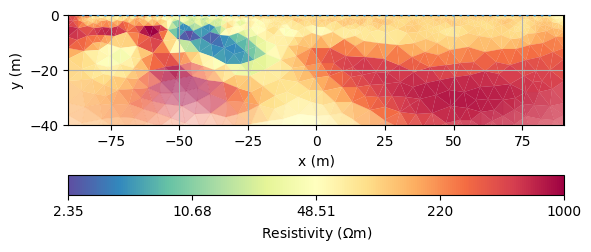

In [269]:
kw = dict(logScale=True, cMap="Spectral_r", xlabel="x (m)", ylabel="y (m)", cMin=0, cMax = 1000)
ax, cb = mgr.showResult(**kw)
ax.grid(True)
ax.set_ylim([-40, ax.get_ylim()[1]])

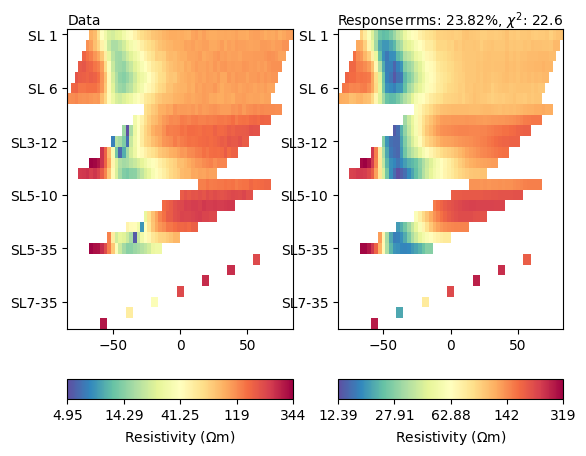

In [270]:
mgr.showFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later